In [ ]:
!mkdir gazeset_1
#!gdown https://drive.google.com/uc?id=1wqTA4gutC-L4h8TcMMQO_3jJYBL15-h3
!unzip -qq "/content/drive/MyDrive/data/UnityEye/UnityEye Archive.zip" -d gazeset_1

!mkdir gazeset
!unzip -qq "/content/drive/MyDrive/data/UnityEye/imgs50.zip" -d gazeset

!mkdir gazeset_2
!unzip -qq "/content/drive/MyDrive/eye_w/imgs.zip" -d gazeset_2

warning [/content/drive/MyDrive/eye_w/imgs.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/eye_w/imgs.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #201878).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
!ls /content/gazeset/imgs | wc -l

107969


In [ ]:
!find /content/gazeset_1/imgs -mindepth 1 -type f -name "*.json" -printf x | wc -c

10791


In [ ]:
!for FILENAME in $(ls /content/gazeset_1/imgs/); do mv /content/gazeset_1/imgs/$FILENAME /content/gazeset_2/imgs/1_$FILENAME; done

In [ ]:
!for FILENAME in $(ls /content/gazeset/imgs/); do mv /content/gazeset/imgs/$FILENAME /content/gazeset_2/imgs/2_$FILENAME; done

In [ ]:
!ls /content/gazeset_2/imgs | wc -l

331429


In [ ]:
!find /content/gazeset_2/imgs -mindepth 1 -type f -name "*.jpg" -printf x | wc -c

165713


In [ ]:
!rm -r eye

rm: cannot remove 'eye': No such file or directory


In [ ]:
!mkdir eye
!git clone https://github.com/Etzelkut/Eye-Tracking.git /content/eye

Cloning into '/content/eye'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 290 (delta 187), reused 182 (delta 88), pack-reused 0
Receiving objects: 100% (290/290), 2.54 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [ ]:
!pip install local-attention
!pip install axial-positional-embedding
!pip install adabelief-pytorch
!pip install ranger-adabelief
!pip install pytorch-lightning
!pip install comet-ml
!pip install einops

  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-py3-none-any.whl size=2901 sha256=eeac351764366c3de503b7856bd8a0a643f8eeb3d68e703361bbb2181feef7d2
  Stored in directory: /root/.cache/pip/wheels/4a/2c/c3/9a1cb267c0d0d9b6eeba7952addb32b17857d1f799690c27a8
Successfully built axial-positional-embedding
     |████████████████████████████████| 526 kB 5.4 MB/s 
     |████████████████████████████████| 133 kB 45.9 MB/s 
     |████████████████████████████████| 829 kB 41.3 MB/s 
     |████████████████████████████████| 396 kB 45.2 MB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
     |████████████████████████████████| 1.1 MB 39.3 MB/s 
     |████████████████████████████████| 271 kB 45.6 MB/s 
     |████████████████████████████████| 160 kB 45.7 MB/s 
     |████████████████████████████████| 144 kB 45.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=cea44016a9856148585a18367a87925c996525bb310207d552

In [ ]:
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import sys

In [ ]:
from eye.basem.basic_dependency import *
from eye.gaze_track.pl_model_train import Gaze_Track_pl
from eye.gaze_track.datasets import Dataset_Unity_pl

In [ ]:
class CheckpointEveryNSteps(pl.Callback):
    """
    Save a checkpoint every N steps, instead of Lightning's default that checkpoints
    based on validation loss.
    """

    def __init__(
        self,
        save_step_frequency,
        prefix="N-Step-Checkpoint",
        use_modelcheckpoint_filename=False,
        pathh = False,
    ):
        """
        Args:
            save_step_frequency: how often to save in steps
            prefix: add a prefix to the name, only used if
                use_modelcheckpoint_filename=False
            use_modelcheckpoint_filename: just use the ModelCheckpoint callback's
                default filename, don't use ours.
        """
        self.save_step_frequency = save_step_frequency
        self.prefix = prefix
        self.use_modelcheckpoint_filename = use_modelcheckpoint_filename
        self.pathh = pathh

    def on_batch_end(self, trainer: pl.Trainer, _):
        """ Check if we should save a checkpoint after every train batch """
        epoch = trainer.current_epoch
        global_step = trainer.global_step
        if global_step % self.save_step_frequency == 0:
            if self.use_modelcheckpoint_filename:
                filename = trainer.checkpoint_callback.filename
            else:
                filename = f"{self.prefix}_{epoch}_{global_step}.ckpt"
            ckpt_path = os.path.join(self.pathh, filename)
            print("we are here!!!")
            trainer.save_checkpoint(ckpt_path)

In [ ]:
base_args = {
    "d": 0,
    "new_d": 256,
    "im_size": (96, 160),
    "patch_size": 16,
    "grayscale": True,
    "max_epochs": 30, 

    "halfing": False,

    "alternative_landmarks": True,
    "add_heatmap_loss": False,
}



########################


main_example_attention_block = {
    "type_module" : "gcn", #att, gcn, gcn_no_wn, linear, rpr, local_sa, glu_alt, light, dynamic
    "d": base_args["new_d"],
    "dropout": 0.05, # in some dropout do not exist
    "num_heads": 2, #if type_module == local_sa, then n_local_attn_heads + global = num_heads
    #params for local_sa
    "n_local_attn_heads": 0,
    "local_attn_window_size": 50,
    #params for glu
    "k_kernel_glu": 4,
    "downbot_glu": 2,
    #for rpr type
    "max_relative_positions_rpr": 8,
    #for dynamic and light
    #"kernel_size_dynamic": 30, 
    #for glu alt
    "alt_num_layers": 1,
    "alt_patch_size": 3,
    "alt_padding": 1,
}

add_example_attention_block = {
    "type_module" : "linear", #att, gcn, gcn_no_wn, linear, rpr, local_sa, glu_alt, #light, dynamic
    "d": base_args["new_d"],
    "dropout": 0.05, # in some dropout do not exist
    "num_heads": 2, #if type_module == local_sa, then n_local_attn_heads + global = num_heads
    #params for local_sa
    "n_local_attn_heads": 0,
    "local_attn_window_size": 50,
    #params for glu
    "k_kernel_glu": 4,
    "downbot_glu": 2,
    #for rpr type
    "max_relative_positions_rpr": 8,
    #for dynamic and light
    #"kernel_size_dynamic": 30, 
    #for glu alt
    "alt_num_layers": 1,
    "alt_patch_size": 3,
    "alt_padding": 1,
}


example_branch = {
    "type_module": "1d", #2d
    "d_model": base_args["new_d"],
    "out_d": 256,
}


example_evolved_encoder_hparams = {
    "d": base_args["new_d"],
    "number_of_main": 1,
    "main_attention_block": main_example_attention_block,
    "branched_conv": example_branch,
    
    "number_of_add": 1,
    "add_attention_block": add_example_attention_block,

    "norm_after_block":False,
}

#########################



example_attention_block = {
    "type_module" : "att", #att, gcn, gcn_no_wn, linear, rpr, local_sa, glu_alt, #light, dynamic
    "d": base_args["new_d"],
    "dropout": 0.05, # in some dropout do not exist
    "num_heads": 4, #if type_module == local_sa, then n_local_attn_heads + global = num_heads
    #params for local_sa
    "n_local_attn_heads": 2,
    "local_attn_window_size": 32,
    #params for glu
    "k_kernel_glu": 4,
    "downbot_glu": 2,
    #for rpr type
    "max_relative_positions_rpr": 8,
    #for dynamic and light
    #"kernel_size_dynamic": 30, 
    #for glu alt
    "alt_num_layers": 1,
    "alt_patch_size": 3,
    "alt_padding": 1,
}


example_encoder_hparams = {
    "attention_block": example_attention_block,
    "d": base_args["new_d"],
    "ff_type": "fc", #fc, conv
    "ff_activation_type": "mish", #swish or gelu
    "ff_glu": False,
    "ff_dropout": 0.05,
    # encoder block params
    "layers_number":2,
    "norm_after_block":False,
    "alternative_weight_init": False,
}


example_emb = {
    "add_emb": False, # if false will run normal embeding from the ViT
    "emb_module": {
        "type_module": "axial", # const
        "d": base_args["new_d"], # dimensions
        "dropout": 0.1,
    }
}


example_resize = {
    "add_resize": True, 
    "resize_module": {
        "type_module": "fc", #fc, 1dconv
        "size": base_args["d"], # dimensions
        "new_size": base_args["new_d"],
    },
}


example_feature_extract_hparams = {
    "grayscale": base_args["grayscale"],
    "im_size": base_args["im_size"],
    "patch_size": base_args["patch_size"],
    "d_model_emb": base_args["new_d"],

    "resize_": example_resize,
    "pos_emb": example_emb,
    "dropout": 0.05,
    "number_of_learn_params": 1,
    "encoder_type": "transformer", # transformer, evolved
    "encoder_params": example_encoder_hparams, #example_evolved_encoder_hparams,

    "alternative_landmarks": base_args["alternative_landmarks"],

    "add_additional_train_landmarks": True,

    "halfing": base_args["halfing"],
    "add_pool_end": False,
}



train_hparams_example = {
    "optimizer": "adamW", # "belief", "ranger_belief", "adam", adamW
    "lr": 3e-4, #
    "epochs": base_args['max_epochs'], #
    #
    "add_sch": False,
    #
    #belief
    "eplison_belief": 1e-16,
    "beta": [0.9, 0.999], # not used
    "weight_decouple": True, 
    "weight_decay": 1e-4,
    "rectify": True,

}

dataset_hparams = {
    "img_dir": "./gazeset_2/imgs",
    "grayscale": base_args["grayscale"],
    "im_size": base_args["im_size"],
    "batch_size": 64,
    "num_workers":2,
    "dataloader_shuffle": True,

    "halfing": base_args["halfing"],

    "alternative_landmarks": base_args["alternative_landmarks"],
}

example_model_hparams = {
    "type": "trans_based", # not used
    "feature_extractor_hparams": example_feature_extract_hparams,

    "alternative_landmarks": base_args["alternative_landmarks"],
    "add_heatmap_loss": base_args["add_heatmap_loss"],
    "im_size": base_args["im_size"],

    "dataset_h": dataset_hparams,

    "mlp_drop": 0.05,
    "gaze_size": 2,
    "training": train_hparams_example,
}

In [ ]:
seed_v = 42
seed_everything(seed_v)

root_dir = "/content/drive/MyDrive/eye_w/weights"
naming = "trans_2_3e4_att_256_1learnparam_noNorm_land_alt_Mdata_"
from datetime import datetime

comet_logger = CometLogger(
  save_dir='/content/log/',
    api_key="23CU99n7TeyZdPeegNDlQ5aHf",
    project_name="gaze2",
    workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)


#
dataset_pl = Dataset_Unity_pl(dataset_hparams)
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))

every_epoch = CheckpointEveryNSteps(save_step_frequency = steps_per_epoch*2, 
                                    use_modelcheckpoint_filename = False, 
                                    pathh=root_dir, prefix=naming+"N-Step-Checkpoint")


proj_a = Gaze_Track_pl(example_model_hparams, steps_per_epoch = steps_per_epoch)


trainer = Trainer(callbacks=[every_epoch],
                  logger=comet_logger,
                  gpus=1,
                  profiler='simple',
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  max_epochs = example_model_hparams["training"]["epochs"],
                  progress_bar_refresh_rate = 0,
                  deterministic=True,)

#~
trainer.fit(proj_a, dataset_pl)
trainer.test(proj_a, dataset_pl)

#if re_dict["training"]["swa"]:
#  proj_a.change_for_swa(dataset_pl.train_dataloader())
#  trainer.test() # will it work?
#.

checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

Global seed set to 42
CometLogger will be initialized in online mode


can add download here
halfing  is  False
alternative_landmarks  is  True
halfing and alt_land is:  False True
train
halfing and alt_land is:  False True
val


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


resize set to:  256  ->  256
adding alternative_landmarks in transformer
running classic ViT_pos_emb
used type is:  {'type_module': 'att', 'd': 256, 'dropout': 0.05, 'num_heads': 4, 'n_local_attn_heads': 2, 'local_attn_window_size': 32, 'k_kernel_glu': 4, 'downbot_glu': 2, 'max_relative_positions_rpr': 8, 'alt_num_layers': 1, 'alt_patch_size': 3, 'alt_padding': 1}
print positionwise Feed Forward with glu:  False
print positionwise Feed Forward with glu:  True
alternative_landmarks is:  True
doint alt landmarks
halfing is:  False
alternative_landmarks  is  True
add_heatmap_loss  is  False


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/etzelkut/gaze2/5e99e22678e14c5f9f28bf948a4da167


  | Name           | Type                  | Params
---------------------------------------------------------
0 | network        | Gaze_Predictor        | 2.2 M 
1 | augment        | DataAugmentationImage | 0     
2 | heatmapLoss    | HeatmapLoss           | 0     
3 | landmarks_loss | MSELoss               | 0     
4 | gaze_loss      | MSELoss               | 0     
---------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.826     T

we are here!!!


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:228: UserWarning:

You called `self.log('epoch_now', ...)` in your `training_epoch_end` but the value needs to be floating point. Converting it to torch.float32.



we are here!!!
we are here!!!


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: Set model graph ignored; already called. Call with overwrite=True to replace graph definition


In [ ]:
#https://arxiv.org/pdf/2007.13120v1.pdf
checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

In [ ]:
################################################################

In [ ]:
seed_v = 42
seed_everything(seed_v)

root_dir = "/content/drive/MyDrive/eye_w/weights"
naming = "trans_2_3e4_att_256_1learnparam_noNorm_land_alt_Mdata"
from datetime import datetime

comet_logger = CometLogger(
  save_dir='/content/log/',
    api_key="23CU99n7TeyZdPeegNDlQ5aHf",
    project_name="gaze2",
    workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)


#

load_name = "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_Mdata_N-Step-Checkpoint_26_53872.ckpt"

proj_a = Gaze_Track_pl.load_from_checkpoint(load_name)

dataset_hparams = proj_a.hparams["dataset_h"]

dataset_pl = Dataset_Unity_pl(dataset_hparams)
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))

every_epoch = CheckpointEveryNSteps(save_step_frequency = steps_per_epoch, 
                                    use_modelcheckpoint_filename = False, 
                                    pathh=root_dir, prefix=naming+"N-Step-Checkpoint")



trainer = Trainer(callbacks=[every_epoch],
                  logger=comet_logger,
                  gpus=1,
                  profiler='simple',
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  max_epochs = proj_a.hparams["training"]["epochs"] + 1,
                  progress_bar_refresh_rate = 0,
                  deterministic=True,
                  resume_from_checkpoint=load_name)

#~
trainer.fit(proj_a, dataset_pl)
trainer.test(proj_a, dataset_pl)

#if re_dict["training"]["swa"]:
#  proj_a.change_for_swa(dataset_pl.train_dataloader())
#  trainer.test() # will it work?
#.

checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

Global seed set to 42
CometLogger will be initialized in online mode


resize set to:  256  ->  256
adding alternative_landmarks in transformer
running classic ViT_pos_emb
used type is:  {'type_module': 'att', 'd': 256, 'dropout': 0.05, 'num_heads': 4, 'n_local_attn_heads': 2, 'local_attn_window_size': 32, 'k_kernel_glu': 4, 'downbot_glu': 2, 'max_relative_positions_rpr': 8, 'alt_num_layers': 1, 'alt_patch_size': 3, 'alt_padding': 1}
print positionwise Feed Forward with glu:  False
print positionwise Feed Forward with glu:  True
alternative_landmarks is:  True
doint alt landmarks
halfing is:  False
alternative_landmarks  is  True
add_heatmap_loss  is  False
can add download here
halfing  is  False
alternative_landmarks  is  True
halfing and alt_land is:  False True
train


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:46: LightningDeprecationWarning:

Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1906: LightningDeprecationWarning:

`trainer.resume_from_checkpoint` is d

halfing and alt_land is:  False True
val


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Failed to check backend version at URL: 'https://www.comet.ml/clientlib/isAlive/ver'
COMET ERROR: Run will not be logged 
For more details, please refer to: https://www.comet.ml/docs/python-sdk/warnings-errors/
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -2] Name or service not kn

we are here!!!


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:228: UserWarning:

You called `self.log('epoch_now', ...)` in your `training_epoch_end` but the value needs to be floating point. Converting it to torch.float32.



we are here!!!
we are here!!!
we are here!!!


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  8744.1         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2142.3         	|4              	|  8569.4         	|  98.001         	|
get_train_batch                    	|  0.81809        	|8292           	|  6783.6         	|  77.579         	|
fetch_next_train_batch             	|  0.81804        	|8292           	|  6783.2         	|  77.574         	|
get_validate_batch                 	|  0.81356        	|1040           	|  846.1          	|  9.6762         	|
fetch_next_validate_batch          

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 7.719670295715332,
 'test_loss_gaze': 0.4327099025249481,
 'test_loss_landmarks': 7.286960601806641}
--------------------------------------------------------------------------------


TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  9192.3         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2142.3         	|4              	|  8569.4         	|  93.223         	|
get_train_batch                    	|  0.81809        	|8292           	|  6783.6         	|  73.797         	|
fetch_next_train_batch             	|  0.81804        	|8292           	|  6783.2         	|  73.792         	|
get_validate_batch                 	|  0.81356        	|1040           	|  846.1          	|  9.2044         	|
fetch_next_validate_batch       

In [ ]:
load_name = "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_30_62160.ckpt"

proj_b = Gaze_Track_pl.load_from_checkpoint(load_name)

resize set to:  256  ->  256
adding alternative_landmarks in transformer
running classic ViT_pos_emb
used type is:  {'type_module': 'att', 'd': 256, 'dropout': 0.05, 'num_heads': 4, 'n_local_attn_heads': 2, 'local_attn_window_size': 32, 'k_kernel_glu': 4, 'downbot_glu': 2, 'max_relative_positions_rpr': 8, 'alt_num_layers': 1, 'alt_patch_size': 3, 'alt_padding': 1}
print positionwise Feed Forward with glu:  False
print positionwise Feed Forward with glu:  True
alternative_landmarks is:  True
doint alt landmarks
halfing is:  False
alternative_landmarks  is  True
add_heatmap_loss  is  False


In [ ]:
trainer.validate(proj_b, dataset_pl.val_dataloader())

In [ ]:
checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

In [ ]:
############################################

In [ ]:
#
from eye.gaze_track.datasets import UnityEyesDataset
from eye.gaze_track.augmentations import DataAugmentationImage, Preprocess
from eye.gaze_track.utils import draw_gaze

import matplotlib.pyplot as plt
import cv2

In [ ]:
26: [{'val_loss': 7.304686546325684,
  'val_loss_gaze': 0.4460446536540985,
  'val_loss_landmarks': 6.858638286590576}]


27: [{'val_loss': 7.412482261657715,
  'val_loss_gaze': 0.40709084272384644,
  'val_loss_landmarks': 7.0053911209106445}]   !!!

/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_27_55944.ckpt



28: [{'val_loss': 7.049773693084717,
  'val_loss_gaze': 0.4825935661792755,
  'val_loss_landmarks': 6.567177772521973}]

29: [{'val_loss': 7.278422832489014,
  'val_loss_gaze': 0.4132797420024872,
  'val_loss_landmarks': 6.865139484405518}]    !!!

/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_29_60088.ckpt



30: [{'val_loss': 7.647112846374512,
  'val_loss_gaze': 0.4213169813156128,
  'val_loss_landmarks': 7.225793361663818}]

/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_30_62160.ckpt


last: [{'val_loss': 7.647112846374512,
  'val_loss_gaze': 0.4213169813156128,
  'val_loss_landmarks': 7.225793361663818}]    !!!

In [ ]:
load_name = "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_30_62160.ckpt"

proj_a = Gaze_Track_pl.load_from_checkpoint(load_name)

resize set to:  256  ->  256
adding alternative_landmarks in transformer
running classic ViT_pos_emb
used type is:  {'type_module': 'att', 'd': 256, 'dropout': 0.05, 'num_heads': 4, 'n_local_attn_heads': 2, 'local_attn_window_size': 32, 'k_kernel_glu': 4, 'downbot_glu': 2, 'max_relative_positions_rpr': 8, 'alt_num_layers': 1, 'alt_patch_size': 3, 'alt_padding': 1}
print positionwise Feed Forward with glu:  False
print positionwise Feed Forward with glu:  True
alternative_landmarks is:  True
doint alt landmarks
halfing is:  False
alternative_landmarks  is  True
add_heatmap_loss  is  False


In [ ]:
#

dataset_val = UnityEyesDataset(img_dir = "./gazeset_2/imgs", val = True, transform = Preprocess(), grayscale = True, output_size = (96, 160), alt_land=True)
val_set = DataLoader(dataset_val, batch_size = 20)
#dd = DataAugmentationImage(1)

halfing and alt_land is:  False True
val


In [ ]:
len(dataset_val)

33143

In [ ]:
#
xx = 0

for bb in val_set:
  xx = bb
  break

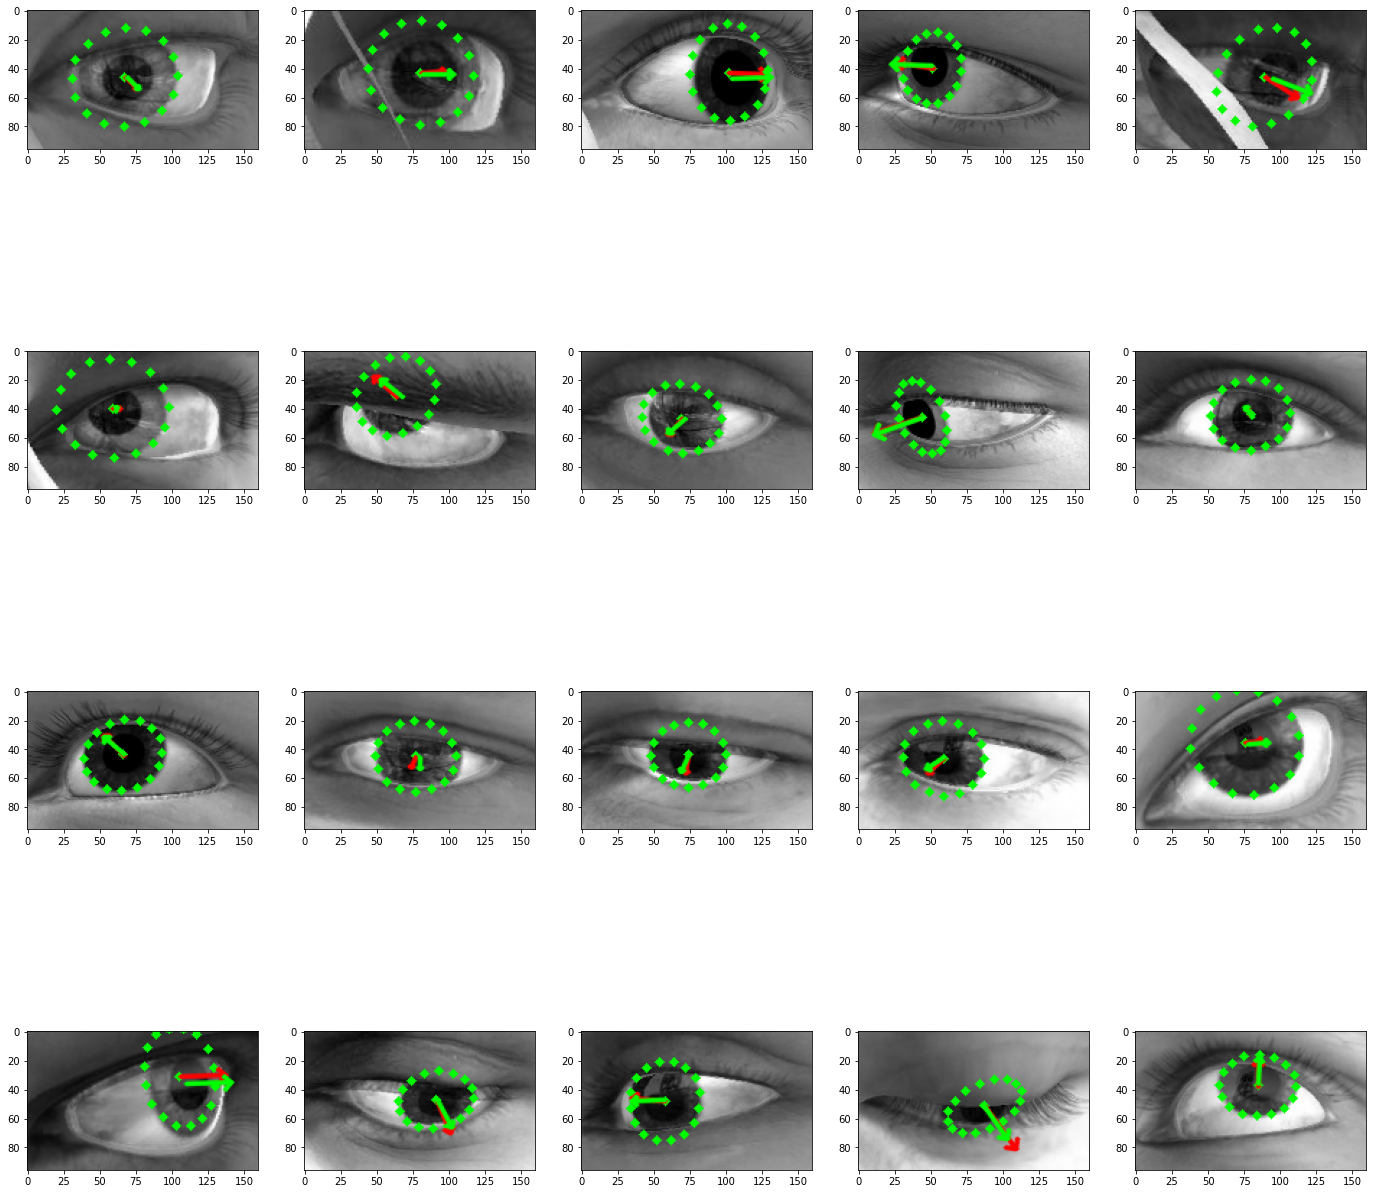

In [ ]:
w = 25
h = 25
fig = plt.figure(figsize=(24, 24))
columns = 5
rows = 4
for i in range(0, columns*rows):

    gaze, heatmaps, landmarks_out = proj_a(xx['img'][i][None])#.to('cuda'))
    xx['img'][i] = xx['img'][i][0]#.to('cpu')[0]

    gaze = gaze[0].detach().numpy()
    image = xx['img'][i].detach().numpy()
    landmarks = landmarks_out.detach().numpy()

    landmarks = proj_a.tranform_into_actual_coor(landmarks)
    landmarks = landmarks[0]

    eye_img = np.copy(image)
    eye_img = eye_img.transpose(1, 2, 0)
    eye_img = cv2.merge((eye_img,eye_img,eye_img))

    eye_img = cv2.normalize(eye_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    eye_img = eye_img.astype(np.uint8)

    landmarks[:, [1, 0]] = landmarks[:, [0, 1]]

    for (x, y) in landmarks[0:]:
        eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 255, 0), thickness=3)
      
    eye_img = draw_gaze(eye_img, landmarks[-1], gaze, color=(255, 0, 0))

    gaze = xx['gaze'][i].detach().numpy()
    landmarks = np.copy(xx['landmarks'][i].detach().numpy())
    
    landmarks = proj_a.tranform_into_actual_coor(landmarks[None])
    landmarks = landmarks[0]

    landmarks[:, [1, 0]] = landmarks[:, [0, 1]]
    eye_img = draw_gaze(eye_img, landmarks[-1], gaze, color=(0, 255, 0))

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(eye_img)

plt.show()

In [ ]:
load_name = "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_30_62160.ckpt"

proj_a = Gaze_Track_pl.load_from_checkpoint(load_name)

proj_a.freeze()
proj_a.eval()
#proj_a.to('cuda')

In [1]:
!mkdir mpi
!tar -xf "/content/drive/MyDrive/eye_w/MPIIGaze.tar.gz" -C mpi

In [2]:
import os
import scipy.io as sio
import numpy as np

In [3]:
def read_files(eval_entries, path):
  eval_entries = []
  full_names = []
  for ef in eval_files:
    person = os.path.splitext(os.path.basename(ef))[0]
    with open(ef) as f:
      lines = f.readlines()
      for line in lines:
        line = line.strip()
        if line != '':
          img_path, side = [x.strip() for x in line.split()]
          day, img = img_path.split('/')
          eval_entries.append({
              'day': day,
              'img_name': img,
              'person': person,
              'side': side
          })
          full_name = os.path.join(person, day, side, img)
          full_names.append(full_name)
  return eval_entries, full_names

In [25]:
def count_size_images(listOfFiles):
  shapes = [0, 0, 0]
  for i, file_name in enumerate(listOfFiles):
    mat = sio.loadmat(listOfFiles[i])
    for side in ['left', 'right']:
      shapes[0] += mat['data'][side][0][0]['image'][0][0].shape[0]
  shapes[1] = mat['data'][side][0][0]['image'][0][0].shape[1]
  shapes[2] = mat['data'][side][0][0]['image'][0][0].shape[2]
  return shapes, mat['data'][side][0][0]['image'][0][0].dtype

In [ ]:
main_path = "./mpi/MPIIGaze"


eval_files = glob.glob(main_path + '/Evaluation Subset/sample list for eye image/*.txt')


In [26]:
main_path = "./mpi/MPIIGaze"

path = main_path + '/Data/Normalized'

listOfFiles = []
for (dirpath, dirnames, filenames) in os.walk(path):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames]

images_index_name = {}


for i, file_name in enumerate(listOfFiles):
  mat = sio.loadmat(listOfFiles[i])


In [27]:
count_size_images(listOfFiles)

([427316, 36, 60], dtype('uint8'))

(1042.0, 1042.0, 410.09213051823417)

In [11]:
import glob
eval_files = glob.glob('./mpi/MPIIGaze/Evaluation Subset/sample list for eye image/*.txt')

In [ ]:
eval_files

In [7]:
mat = sio.loadmat(listOfFiles[0])

In [13]:
mat['data']['left'][0][0]['image'][0][0].shape

(765, 36, 60)

In [12]:
mat['filenames'].shape

(765, 1)

In [15]:
mat['data']

array([[(array([[(array([[ 0.00391588,  0.00958536, -0.99994639],
       [ 0.1764957 ,  0.30246789, -0.93667627],
       [ 0.17126967,  0.2078212 , -0.9630561 ],
       ...,
       [ 0.18925354,  0.03712992, -0.981226  ],
       [ 0.17823082,  0.14671927, -0.97298881],
       [ 0.04294497,  0.01200707, -0.99900529]]), array([[[133, 125, 133, ..., 203, 216, 225],
        [133, 138, 138, ..., 189, 203, 212],
        [146, 154, 154, ..., 175, 185, 189],
        ...,
        [133, 133, 125, ...,  73,  77,  88],
        [133, 138, 133, ...,  77,  77,  96],
        [146, 146, 146, ...,  96,  96, 106]],

       [[167, 167, 167, ..., 150, 167, 186],
        [186, 186, 177, ..., 127, 144, 155],
        [199, 199, 195, ..., 120, 135, 144],
        ...,
        [205, 201, 205, ..., 135, 127, 144],
        [224, 216, 216, ..., 135, 135, 144],
        [238, 235, 231, ..., 150, 150, 155]],

       [[152, 159, 144, ..., 186, 203, 213],
        [166, 166, 152, ..., 166, 186, 196],
        [178, 178, 1

In [ ]:
from __future__ import print_function, division

import glob
#import os
#import cv2
import scipy.io as sio

import torchvision.transforms.functional as TF
from torchvision import transforms


class MPIIGaze(Dataset):
  def __init__(self, val = False, mpii_dir = './mpi/MPIIGaze'):

    self.paths = 



        self.mpii_dir = mpii_dir

        eval_files = glob.glob(f'{mpii_dir}/Evaluation Subset/sample list for eye image/*.txt')

        self.trans = MPI_Preprocess()



    def __len__(self):
        return len(self.eval_entries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self._load_sample(idx)

    def _load_sample(self, i):
        entry = self.eval_entries[i]
        mat_path = os.path.join(self.mpii_dir, 'Data/Normalized', entry['person'], entry['day'] + '.mat')
        mat = sio.loadmat(mat_path)

        filenames = mat['filenames']
        row = np.argwhere(filenames == entry['img_name'])[0][0]
        side = entry['side']

        img = mat['data'][side][0, 0]['image'][0, 0][row]

        if side == 'right':
            img = np.fliplr(img)
        
        img = self.trans(img)

        (x, y, z) = mat['data'][side][0, 0]['gaze'][0, 0][row]

        theta = np.arcsin(-y)
        phi = np.arctan2(-x, -z)
        gaze = np.array([-theta, phi])

        return {
            'img': img,
            'gaze': gaze,
            'side': side
        }

In [ ]:
from __future__ import print_function, division

import glob
#import os
#import cv2
import scipy.io as sio

import torchvision.transforms.functional as TF
from torchvision import transforms

class MPI_Preprocess(nn.Module):

    def __init__(self):
      super().__init__()
      self.norm = transforms.Normalize([0.5], [0.5])

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x):

        img = TF.to_tensor(x.copy()) # CxHxW
        #print("preproccess")
        #print(torch.max(x_out))
        #print(torch.min(x_out))
        img = img.float()

        x, y = (96, 160)
        x = int((256/224) * x)
        y = int((256/224) * y)
        output_size = (x, y)
        img = TF.resize(img, output_size)


        h, w = img.shape[-2:]
        new_h, new_w = (96, 160)

        top =  int((h - new_h)/2)
        left =  int((w - new_w)/2)

        img = img[:, top: top + new_h, left: left + new_w]

        img = self.norm(img)

        return img

#"./gazeset/imgs"

class MPIIGaze(Dataset):

    def __init__(self, mpii_dir: str = './mpi/MPIIGaze'):

        self.mpii_dir = mpii_dir

        eval_files = glob.glob(f'{mpii_dir}/Evaluation Subset/sample list for eye image/*.txt')

        self.trans = MPI_Preprocess()

        self.eval_entries = []
        for ef in eval_files:
            person = os.path.splitext(os.path.basename(ef))[0]
            with open(ef) as f:
                lines = f.readlines()
                for line in lines:
                    line = line.strip()
                    if line != '':
                        img_path, side = [x.strip() for x in line.split()]
                        day, img = img_path.split('/')
                        self.eval_entries.append({
                            'day': day,
                            'img_name': img,
                            'person': person,
                            'side': side
                        })

    def __len__(self):
        return len(self.eval_entries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self._load_sample(idx)

    def _load_sample(self, i):
        entry = self.eval_entries[i]
        mat_path = os.path.join(self.mpii_dir, 'Data/Normalized', entry['person'], entry['day'] + '.mat')
        mat = sio.loadmat(mat_path)

        filenames = mat['filenames']
        row = np.argwhere(filenames == entry['img_name'])[0][0]
        side = entry['side']

        img = mat['data'][side][0, 0]['image'][0, 0][row]

        if side == 'right':
            img = np.fliplr(img)
        
        img = self.trans(img)

        (x, y, z) = mat['data'][side][0, 0]['gaze'][0, 0][row]

        theta = np.arcsin(-y)
        phi = np.arctan2(-x, -z)
        gaze = np.array([-theta, phi])

        return {
            'img': img,
            'gaze': gaze,
            'side': side
        }

In [ ]:
def pitchyaw_to_vector(pitchyaws):
    r"""Convert given yaw (:math:`\theta`) and pitch (:math:`\phi`) angles to unit gaze vectors.
    Args:
        pitchyaws (:obj:`numpy.array`): yaw and pitch angles :math:`(n\times 2)` in radians.
    Returns:
        :obj:`numpy.array` of shape :math:`(n\times 3)` with 3D vectors per row.
    """
    n = pitchyaws.shape[0]
    sin = np.sin(pitchyaws)
    cos = np.cos(pitchyaws)
    out = np.empty((n, 3))
    out[:, 0] = np.multiply(cos[:, 0], sin[:, 1])
    out[:, 1] = sin[:, 0]
    out[:, 2] = np.multiply(cos[:, 0], cos[:, 1])
    return out

In [ ]:
radians_to_degrees = 180.0 / np.pi


def angularError(a, b):
    """Calculate angular error (via cosine similarity)."""
    a = pitchyaw_to_vector(a) if a.shape[1] == 2 else a
    b = pitchyaw_to_vector(b) if b.shape[1] == 2 else b

    ab = np.sum(np.multiply(a, b), axis=1)
    a_norm = np.linalg.norm(a, axis=1)
    b_norm = np.linalg.norm(b, axis=1)

    # Avoid zero-values (to avoid NaNs)
    a_norm = np.clip(a_norm, a_min=1e-7, a_max=None)
    b_norm = np.clip(b_norm, a_min=1e-7, a_max=None)

    similarity = np.divide(ab, np.multiply(a_norm, b_norm))

    return np.arccos(similarity) * radians_to_degrees

In [ ]:
#from util.preprocess import gaussian_2d
#from matplotlib import pyplot as plt
#import util.gaze

#from eye.gaze_track.utils import draw_gaze
#import matplotlib.pyplot as plt


datasetm = MPIIGaze()

eyenet = proj_a.to(device)

errors = []

biggest_errors = [0] * 20
index_of_big_error = [0] * 20

random_indexes = sorted(
    np.random.choice(len(datasetm), size=20, replace=False)
)

print('N', len(datasetm))
for i, sample in enumerate(datasetm):
  img = sample['img'][None].to(device)

  gaze_pred2, heatmaps_pred2, landmarks_pred2 = eyenet.forward(img)

  gaze2 = sample['gaze'].reshape((1, 2))
  gaze_pred2 = np.asarray(gaze_pred2.cpu().numpy())

  if sample['side'] == 'right':
      gaze_pred2[0, 1] = -gaze_pred2[0, 1]

  angular_error = angularError(gaze2, gaze_pred2)

  for j, errorval in enumerate(biggest_errors):
    if angular_error > errorval:
      biggest_errors[j] = angular_error

      sorted_indexes = sorted(range(len(biggest_errors)),key=biggest_errors.__getitem__)
      biggest_errors = sorted(biggest_errors)

      index_of_big_error[sorted_indexes.index(j)] = i

      break
 

  errors.append(angular_error)

  """
  gaze_pred2 = gaze_pred2[0]


  landmarks_pred2 = proj_a.tranform_into_actual_coor(landmarks_pred2)
  landmarks_pred2 = landmarks_pred2[0].numpy()#.detach().numpy()


  eye_img = np.copy(img[0])
  eye_img = eye_img.transpose(1, 2, 0)
  eye_img = cv2.merge((eye_img,eye_img,eye_img))

  eye_img = cv2.normalize(eye_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  eye_img = eye_img.astype(np.uint8)

  landmarks_pred2[:, [1, 0]] = landmarks_pred2[:, [0, 1]]

  for (x, y) in landmarks_pred2[0:]:
      eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 255, 0), thickness=3)
    
  eye_img = draw_gaze(eye_img, landmarks_pred2[-1], gaze_pred2, color=(255, 0, 0))
  
  plt.imshow(eye_img)
  """

  if i%1000 == 0:
    print('---', i)
    print('error', angular_error)
    print('mean error', np.mean(errors))
    print('side', sample['side'])
    print('gaze', gaze2)
    print('gaze pred', gaze_pred2)


N 45000
--- 0
error [3.32945261]
mean error 3.329452610724305
side left
gaze [[0.25437489 0.21024275]]
gaze pred [[0.19675677 0.21798426]]
--- 1000
error [7.37395527]
mean error 14.454972532037926
side left
gaze [[ 0.20272926 -0.19148246]]
gaze pred [[ 0.0742097 -0.1983623]]
--- 2000
error [29.9103649]
mean error 13.32963172632741
side right
gaze [[ 0.26886991 -0.05764448]]
gaze pred [[0.292921   0.48565146]]
--- 3000
error [17.63044616]
mean error 12.650509762729206
side left
gaze [[ 0.1988328 -0.0411715]]
gaze pred [[ 0.0253271  -0.29724663]]
--- 4000
error [5.67770446]
mean error 12.454661341333859
side left
gaze [[0.20257022 0.20002757]]
gaze pred [[0.11323963 0.15657878]]
--- 5000
error [6.17762017]
mean error 12.665396675871966
side right
gaze [[ 0.13524639 -0.14448761]]
gaze pred [[ 0.08892176 -0.04650237]]
--- 6000
error [18.15210487]
mean error 13.085010906866005
side left
gaze [[0.05211857 0.24736058]]
gaze pred [[-0.12661113 -0.01475837]]
--- 7000
error [14.5716584]
mean err

In [ ]:
print('mean error', np.mean(errors))

mean error 14.594999066209782


In [ ]:
gelu, adjust transformation, add 
visual layers, add tokenize?

In [ ]:
mean error 16.43294590721282 for "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_N-Step-Checkpoint_29_23490.ckpt"
mean error 14.124033660298325 for "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_27_55944.ckpt"
mean error 13.448220713857355 for "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_29_60088.ckpt"
mean error 14.594999066209782 for "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_alt_MdataN-Step-Checkpoint_30_62160.ckpt"

In [ ]:
print(biggest_errors, "\n") 
print(index_of_big_error, "\n") 

print(random_indexes, "\n") 

[array([73.84391799]), array([73.99576025]), array([74.00420659]), array([74.73143349]), array([74.98818027]), array([74.99804353]), array([75.12068332]), array([75.18696597]), array([75.33113766]), array([75.88369137]), array([76.09215985]), array([76.70452539]), array([76.94135722]), array([77.88475657]), array([79.01599785]), array([81.47784336]), array([81.86284354]), array([83.37548945]), array([84.63392832]), array([91.4699733])] 

[14413, 20786, 23215, 36824, 21221, 23024, 772, 23027, 23270, 44371, 31684, 21736, 11818, 12804, 31599, 8801, 43720, 14889, 13711, 13871] 

[732, 2149, 3723, 3992, 5203, 8116, 8508, 17575, 18645, 20895, 23925, 28679, 30595, 31680, 32135, 36478, 38010, 40337, 44360, 44931] 



732 [30.06450497]
2149 [13.67200157]
3723 [12.21253246]
3992 [3.99470995]
5203 [9.83212196]
8116 [15.68904772]
8508 [16.11823956]
17575 [9.95756056]
18645 [43.77564342]
20895 [13.63200633]
23925 [19.45706459]
28679 [7.41075136]
30595 [17.39352429]
31680 [9.15777704]
32135 [29.14507348]
36478 [8.66523281]
38010 [8.3401231]
40337 [12.7233353]
44360 [16.917551]
44931 [7.75139573]


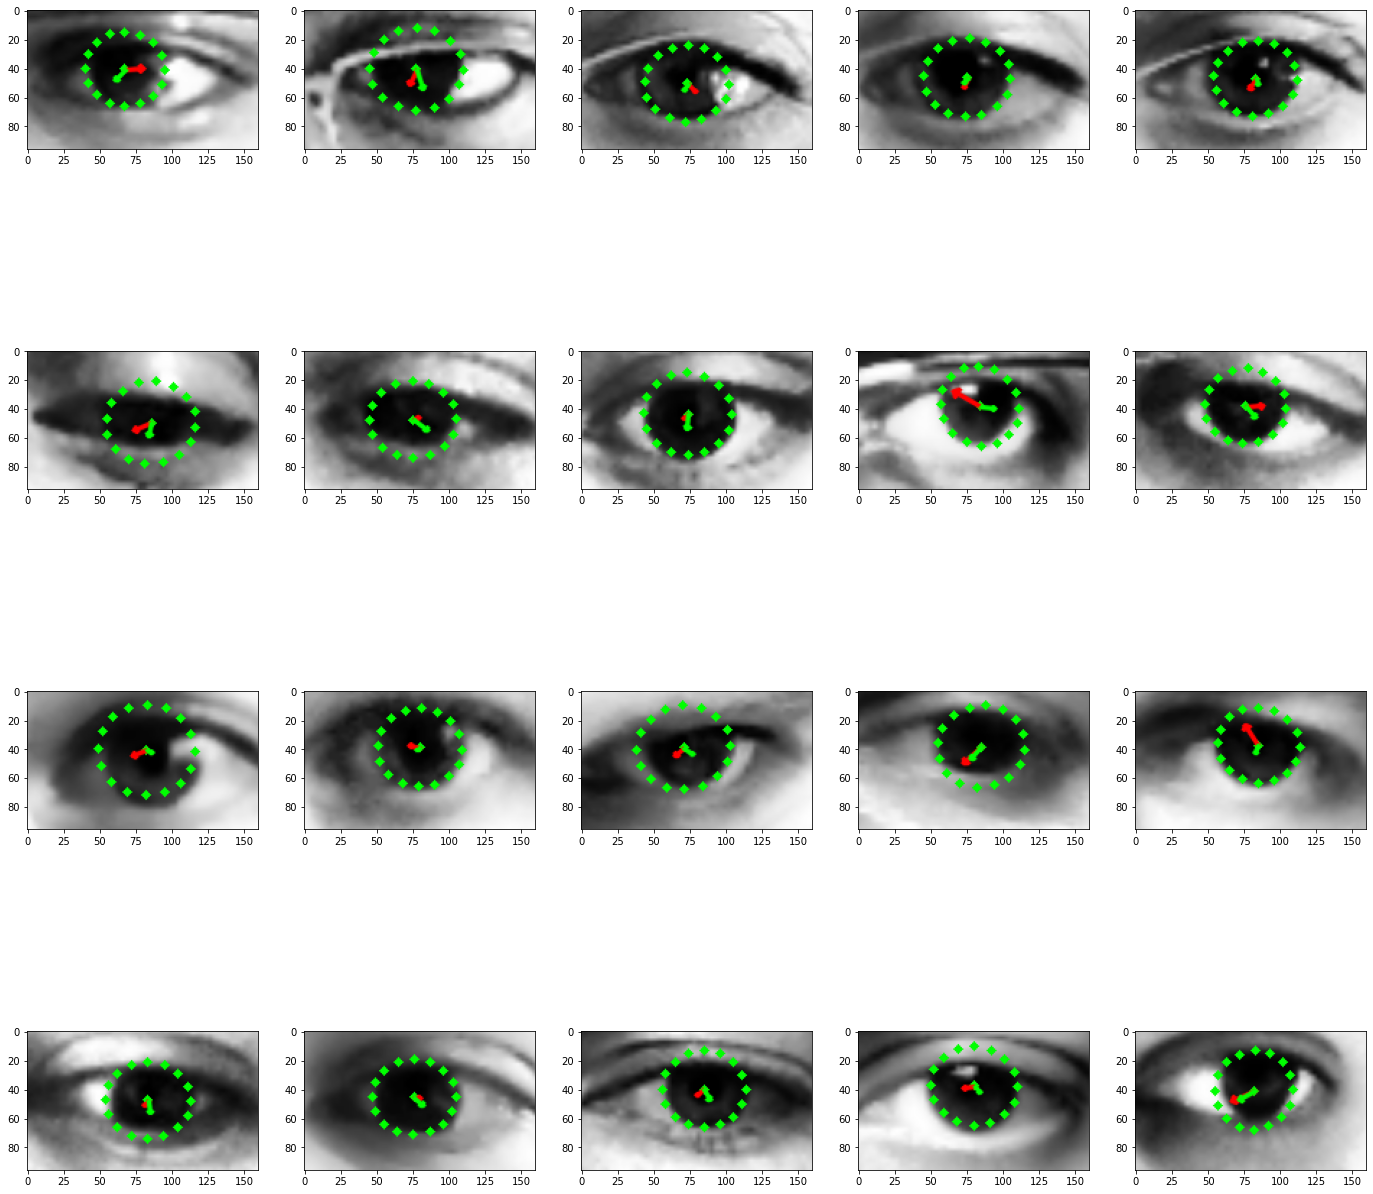

In [ ]:
w = 25
h = 25
fig = plt.figure(figsize=(24, 24))
columns = 5
rows = 4

i = 0

for index in random_indexes:

  img = dataset[index]['img'][None]#.to(device)
  gaze_pred, heatmaps_pred, landmarks_pred = eyenet.forward(img)
  gaze = dataset[index]['gaze'].reshape((1, 2))
  gaze_pred = np.asarray(gaze_pred.numpy()) # .cpu()  

  if sample['side'] == 'right':
    print("right")
    gaze_pred[0, 1] = -gaze_pred[0, 1]
  else:
    print("left")

  angular_error = angularError(gaze, gaze_pred)
  
  gaze_pred = gaze_pred[0]
  gaze = gaze[0]

  landmarks_pred = landmarks_pred.numpy()

  landmarks_pred = proj_a.tranform_into_actual_coor(landmarks_pred)
  landmarks_pred = landmarks_pred[0]

  eye_img = np.copy(img[0])
  eye_img = eye_img.transpose(1, 2, 0)
  eye_img = cv2.merge((eye_img,eye_img,eye_img))

  eye_img = cv2.normalize(eye_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  eye_img = eye_img.astype(np.uint8)

  landmarks_pred[:, [1, 0]] = landmarks_pred[:, [0, 1]]

  for (x, y) in landmarks_pred[0:]:
    eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 255, 0), thickness=3)
    
  eye_img = draw_gaze(eye_img, landmarks_pred[-1], gaze_pred, color=(255, 0, 0))

  eye_img = draw_gaze(eye_img, landmarks_pred[-1], gaze, color=(0, 255, 0))

  print(index, angular_error)

  fig.add_subplot(rows, columns, i+1)
  plt.imshow(eye_img)

  i+=1


plt.show()

In [ ]:
#
w = 25
h = 25
fig = plt.figure(figsize=(20, 20))
columns = 5
rows = 2
for i in range(0, columns*rows):

    print("before norm")
    print(i, xx['img'][i].size(), torch.min(xx['img'][i]), torch.max(xx['img'][i]))
    
    xx['img'][i] = dd(xx['img'][i][None].to('cuda'), 1)
    xx['img'][i] = xx['img'][i].to('cpu')[0]

    print("after norm")
    print(i, xx['img'][i].size(), torch.min(xx['img'][i]), torch.max(xx['img'][i]))

    gaze = xx['gaze'][i].detach().numpy()
    image = xx['img'][i].detach().numpy()
    landmarks = np.copy(xx['landmarks'][i].detach().numpy())

    eye_img = np.copy(image)
    eye_img = eye_img.transpose(1, 2, 0)
    eye_img = cv2.merge((eye_img,eye_img,eye_img))

    eye_img = cv2.normalize(eye_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    eye_img = eye_img.astype(np.uint8)

    landmarks[:, [1, 0]] = landmarks[:, [0, 1]]

    for (x, y) in landmarks[0:]:
        eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 255, 0), thickness=3)
        
    eye_img = draw_gaze(eye_img, landmarks[-1], gaze, color=(255, 0, 0))

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(eye_img)

plt.show()

In [ ]:
im read
0
255
im preprocess_unityeyes_image
0
255
preproccess
tensor(1.)
tensor(0.)
after preproccess
tensor(1.)
tensor(0.)
after grayacale
tensor(0.8911)
tensor(0.)
val

after norm
0 torch.Size([1, 96, 160]) tensor(-1.) tensor(0.7582)


im read
0
255
im preprocess_unityeyes_image
0
219
preproccess
tensor(0.8588)
tensor(0.)
after preproccess
tensor(0.8588)
tensor(0.)
after grayacale
tensor(0.7972)
tensor(0.)
train
random size:  (329, 493)



before norm
0 torch.Size([1, 96, 160]) tensor(0.) tensor(0.6943)
random aug
tensor(0.4221, device='cuda:0')
tensor(0.0380, device='cuda:0')
random noise
tensor(0.4375, device='cuda:0')
tensor(0.0114, device='cuda:0')
norm
after norm
0 torch.Size([1, 96, 160]) tensor(-0.9772) tensor(-0.1251)




before norm
1 torch.Size([1, 96, 160]) tensor(0.) tensor(0.8828)
random aug
tensor(1.0000, device='cuda:0')
tensor(5.8192e-31, device='cuda:0')
random noise
tensor(1.0383, device='cuda:0')
tensor(-0.0299, device='cuda:0')
norm
after norm
1 torch.Size([1, 96, 160]) tensor(-1.0598) tensor(1.0767)


before norm
2 torch.Size([1, 96, 160]) tensor(0.) tensor(0.9706)
random aug
tensor(0.9673, device='cuda:0')
tensor(0., device='cuda:0')
norm
after norm
2 torch.Size([1, 96, 160]) tensor(-1.) tensor(0.9345)



In [ ]:
im read
0
255
im preprocess_unityeyes_image
0
255
preproccess
tensor(1.)
tensor(0.)
after preproccess
tensor(0.0039)
tensor(0.)
after grayacale
tensor(0.0035)
tensor(0.)
val

after norm
0 torch.Size([1, 96, 160]) tensor(-1.) tensor(-0.9931)



im read
0
255
im preprocess_unityeyes_image
0
219
preproccess
tensor(0.8588)
tensor(0.)
after preproccess
tensor(0.0034)
tensor(0.)
after grayacale
tensor(0.0031)
tensor(0.)
train

before norm
0 torch.Size([1, 96, 160]) tensor(0.) tensor(0.0026)
random aug
tensor(0.0025, device='cuda:0')
tensor(0.0001, device='cuda:0')
random noise
tensor(4.3869, device='cuda:0')
tensor(-3.8716, device='cuda:0')
norm
after norm
0 torch.Size([1, 96, 160]) tensor(-8.7432) tensor(7.7739)


before norm
2 torch.Size([1, 96, 160]) tensor(0.) tensor(0.0038)
random aug
tensor(0.0027, device='cuda:0')
tensor(0.0002, device='cuda:0')
norm
after norm
2 torch.Size([1, 96, 160]) tensor(-0.9997) tensor(-0.9945)